In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from scipy import stats
import matplotlib.dates as mdates
from plotly import tools
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

init_notebook_mode(connected=True)
%matplotlib inline
# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
import warnings
warnings.filterwarnings("ignore")

In [5]:
import mplfinance as mpf
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

In [9]:
df = pd.read_excel("forecasting.xlsx")
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m-%d')
df['COP'] =df['COP'] / 1000000
df.head()

,Canal,Nit_Cliente,Razon_Social_Cliente,Fecha,COP
0,Canal Droguerias,800052534,Distribuciones Axa Sas,2019-06-01,123.303381
1,Canal Droguerias,800052534,Distribuciones Axa Sas,2019-08-01,56.887238
2,Canal Droguerias,800052534,Distribuciones Axa Sas,2019-10-01,66.770925
3,Canal Droguerias,800052534,Distribuciones Axa Sas,2019-12-01,92.460422
4,Canal Droguerias,800052534,Distribuciones Axa Sas,2020-04-01,91.044613


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Canal                 2516 non-null   object        
 1   Nit_Cliente           2516 non-null   int64         
 2   Razon_Social_Cliente  2516 non-null   object        
 3   Fecha                 2516 non-null   datetime64[ns]
 4   COP                   2516 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 98.4+ KB


In [12]:
def information_function(data):
    print(f'Unique Clients {df.Razon_Social_Cliente.unique()}')
    print('------'*20)
    
    print('Print metadata')
    print(df.info())
    print('------'*20)
    
    null_ = df.isnull().sum()
    print(null_)
    print('------'*20)
    
    delta = (df['Fecha'].max() - df['Fecha'].min())
    print(f'Time Delta: {delta}')
    print('------'*20)
    
    print('Print describe')
    print(df.describe().T)
    
information_function(df)

Unique Clients ['Distribuciones Axa Sas' 'Deposito De Drogas Profesional Sas'
 'Drog Y Farmacias Cruz Verde Sas' 'Drosan Ltda' 'Drogas S Y S Sas'
 'Deposito De Drogas Monaco Sa'
 'Comercializadora Multidrogas De Colombia Sas' 'Copservir Ltda'
 'Farmatodo Colombia Sa' 'Locatel Colombia  Sas' 'Colsubsidio' 'Cafam'
 'Cooperativa Nacional De Droguistas Detallistas'
 'Union De Droguistas Sas Unidrogas Sas' 'Comfamiliar Andi Comfandi'
 'Distribuidora Farmaceutica Roma Sa' 'Distribuidora Pasteur Sa'
 'Eve Distribuciones Sas' 'Eticos Serrano Gomez Ltda'
 'Dromedicas Del Oriente Sas' 'Mercado Zapatoca Sa'
 'Homecenter Sodimac Colombia Sa' 'Comercializadora Floralia Sa'
 'Supertiendas Canaveral Sas' 'Inversiones Euro Sa' 'Mecanelectro Sas'
 'Almacenes Maximo Sas'
 'Caja De Compensacion De Fenalco Seccional Quindio'
 'Supertiendas Y Droguerias Olimpica Sa' 'Almacenes La 14 Sa'
 'Almacenes Exito Sa' 'Colombiana De Comercio Sa'
 'Makro Supermayorista Sas' 'Mercamio Sa'
 'Supermercados Mas Por Menos

In [14]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_time_series(data, x, y):
    for i, j in enumerate(data[data.Canal == 'Canal Moderno']['Razon_Social_Cliente'].unique()):
        df_ = data[data.Razon_Social_Cliente == j].groupby([x], as_index=False)[y].sum()

        # Use Plotly
        trace = go.Scatter(x=df_[x].sort_values(), y=df_[y], mode='lines', name='lines')
        layout = go.Layout(title=f'Time Series {j}', xaxis=dict(title='Date'), yaxis=dict(title='COP'))
        fig = go.Figure(data=[trace], layout=layout)
        iplot(fig)

plot_time_series(df, 'Fecha', 'COP')

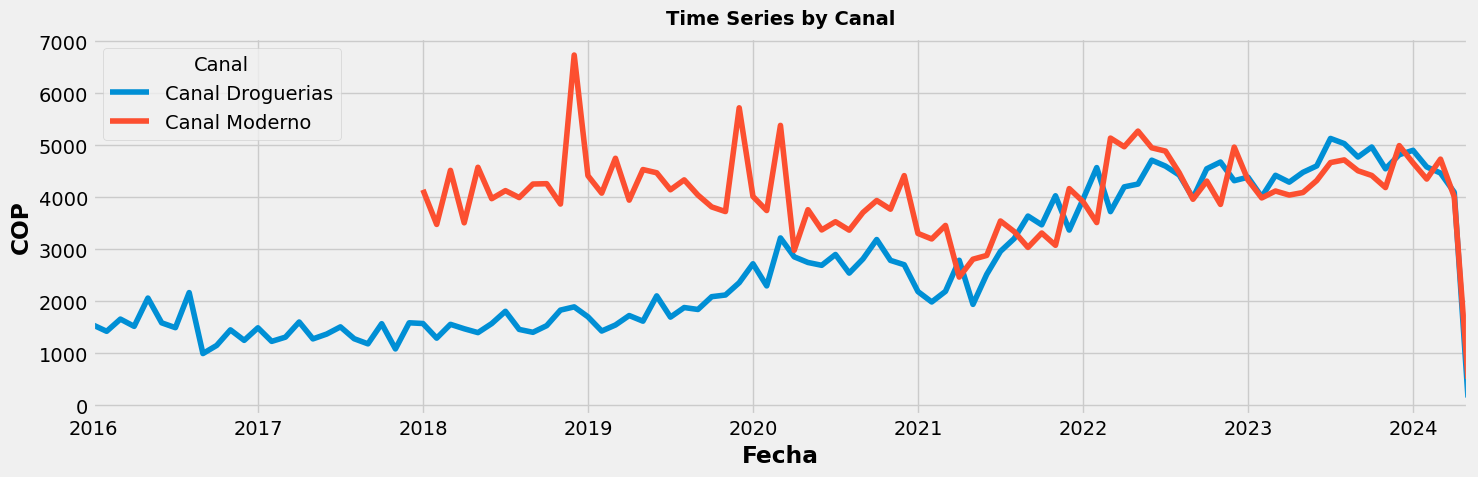

In [15]:
import plotly.graph_objs as go
from plotly.offline import iplot


import matplotlib.pyplot as plt

df.groupby(['Fecha', 'Canal'], as_index=False)['COP'].sum().pivot(index='Fecha', columns='Canal', values='COP').plot(kind='line', figsize=(15, 5))
plt.xlabel('Fecha')
plt.ylabel('COP')
plt.title('Time Series by Canal')
plt.show()

# do it with plotly

import plotly.graph_objs as go
from plotly.offline import iplot

# Group by Fecha and Canal, sum COP, then pivot the table
pivot_df = df.groupby(['Fecha', 'Canal'], as_index=False)['COP'].sum().pivot(index='Fecha', columns='Canal', values='COP')

# Create traces for each Canal
traces = []
for column in pivot_df.columns:
    trace = go.Scatter(x=pivot_df.index, y=pivot_df[column], mode='lines', name=column)
    traces.append(trace)

# Create layout
layout = go.Layout(title='Time Series by Canal', xaxis=dict(title='Fecha'), yaxis=dict(title='COP'))

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Display the plot
iplot(fig)





In [16]:
def plot_time_series(data, x, y):
    for i, j in enumerate(data['Razon_Social_Cliente'].unique()):
        df_ = data[data.Razon_Social_Cliente == j].groupby([x], as_index=False)[y].sum()

        # Use Plotly
        trace = go.Scatter(x=df_[x].sort_values(), y=df_[y], mode='lines', name='lines')
        layout = go.Layout(title=f'Time Series {j}', xaxis=dict(title='Date'), yaxis=dict(title='COP'))
        fig = go.Figure(data=[trace], layout=layout)
        iplot(fig)

In [17]:
mean_dict = {}

for key in df['Razon_Social_Cliente'].unique():
    mean_dict[key] = df[df['Razon_Social_Cliente'] == key]['COP'].mean()
    
print('lenght of the mean of Clients dictionary:', len(mean_dict))

average_s = pd.Series(mean_dict).T
top1_s = average_s.sort_values(ascending=False)[:4]
print('Top 10 Clientes with highest mean value from sales:\n', top1_s)

lenght of the mean of Clients dictionary: 42
Top 10 Clientes with highest mean value from sales:
 Almacenes Exito Sa                                1463.137260
Cooperativa Nacional De Droguistas Detallistas    1206.168431
Cencosud Colombia Sa                               762.739236
Supertiendas Y Droguerias Olimpica Sa              746.732225
dtype: float64


In [18]:
def subdataframe(data, column):
    clients = list(top1_s.index)
    
    assert column in clients, 'Column not in the top 10 clients'
    
    return data[data['Razon_Social_Cliente'] == column]

In [19]:
exit_df = subdataframe(df, 'Almacenes Exito Sa')
coopi_df = subdataframe(df, 'Cooperativa Nacional De Droguistas Detallistas')
cenco_df = subdataframe(df, 'Cencosud Colombia Sa')
olimpica_df = subdataframe(df, 'Supertiendas Y Droguerias Olimpica Sa')

In [20]:
exit_df

,Canal,Nit_Cliente,Razon_Social_Cliente,Fecha,COP
1799,Canal Moderno,890900608,Almacenes Exito Sa,2018-01-01,1868.643081
1800,Canal Moderno,890900608,Almacenes Exito Sa,2018-04-01,1417.013398
1801,Canal Moderno,890900608,Almacenes Exito Sa,2018-06-01,1672.318444
1802,Canal Moderno,890900608,Almacenes Exito Sa,2018-08-01,1366.681073
1803,Canal Moderno,890900608,Almacenes Exito Sa,2018-10-01,1694.015364
...,...,...,...,...,...
2254,Canal Moderno,890900608,Almacenes Exito Sa,2022-10-01,1410.466399
2255,Canal Moderno,890900608,Almacenes Exito Sa,2022-12-01,1660.791611
2256,Canal Moderno,890900608,Almacenes Exito Sa,2023-03-01,1363.055845
2257,Canal Moderno,890900608,Almacenes Exito Sa,2023-05-01,1203.622382


In [ ]:
def cop_client(df):
    high = df['COP'].max()
    low = df['COP'].min()
    
    datetime = df[df['COP'] == high]['Fecha']]['Fecha'].values
    
    id df[]